In [14]:
#Predicting Federal Reserve Interest Rate Decisions
#Importing Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [15]:
#Loading the data
data = pd.read_csv('PCE_FedFunds.csv')

#Checking the data
data.head()

,Date,PCE,Federal Reserve Rate,FedRate Movement
0,1959-01-01,306091,2.48,0.00
1,1959-02-01,309554,2.43,-0.05
2,1959-03-01,312702,2.80,0.37
3,1959-04-01,312193,2.96,0.16
4,1959-05-01,316130,2.90,-0.06


In [16]:
#Base the movement classification on the standard deviation of the data start with .5
#adjust for better accuracy
sd = data['FedRate Movement'].std()

#Define threshold for movement classificaiton
upper_threshold = .5 * sd
lower_threshold = -.5 * sd

#assign labels
def classify_rate_change(change):
    if change > upper_threshold:
        return 1
    elif change < lower_threshold:
        return -1
    else:
        return 0
    
#Create a new column for the classification
data['Rate Movement'] = data['FedRate Movement'].apply(classify_rate_change)

#Checking the data
data.head(10)

,Date,PCE,Federal Reserve Rate,FedRate Movement,Rate Movement
0,1959-01-01,306091,2.48,0.00,0
1,1959-02-01,309554,2.43,-0.05,0
2,1959-03-01,312702,2.80,0.37,1
3,1959-04-01,312193,2.96,0.16,0
4,1959-05-01,316130,2.90,-0.06,0
5,1959-06-01,318193,3.39,0.49,1
6,1959-07-01,317787,3.47,0.08,0
7,1959-08-01,320161,3.50,0.03,0
8,1959-09-01,324228,3.76,0.26,1
9,1959-10-01,322794,3.98,0.22,0


In [17]:
#verify integer values for Rate Movement
data['Rate Movement'].dtype

dtype('int64')

In [18]:
#Check the value counts of the new column
data['Rate Movement'].value_counts()

Rate Movement
 0    564
-1    120
 1    106
Name: count, dtype: int64

In [19]:
#check columns
data.columns


Index(['Date', 'PCE', 'Federal Reserve Rate', 'FedRate Movement',
       'Rate Movement'],
      dtype='object')

In [20]:
#convert date to datetime
data['Date'] = pd.to_datetime(data['Date'])

In [21]:
data.dtypes

Date                    datetime64[ns]
PCE                              int64
Federal Reserve Rate           float64
FedRate Movement               float64
Rate Movement                    int64
dtype: object

In [22]:
#Copy data to new dataframe
data2 = data.copy()

#confirm the data was saved
print('Data Saved')


Data Saved


In [23]:
#Define features and target
X = data2[['PCE']]
y = data2['Rate Movement']

In [24]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#print the shape of the training and testing sets

print(X_train.shape)
print(X_test.shape)

(553, 1)
(237, 1)


In [25]:
#Initialize the model
model = RandomForestClassifier(n_estimators=64, random_state=42)

#Fit the model
model.fit(X_train, y_train)



RandomForestClassifier(n_estimators=64, random_state=42)

In [26]:
#make predictions
y_pred = model.predict(X_test)

#Check the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.41      0.37      0.39        38
           0       0.78      0.82      0.80       168
           1       0.32      0.29      0.31        31

    accuracy                           0.68       237
   macro avg       0.51      0.49      0.50       237
weighted avg       0.66      0.68      0.67       237



# Model Evaluation

In [27]:
# Calculate the accuracy score
acc_score = accuracy_score(y_test, y_pred)

# Display results
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.6751054852320675


In [28]:
# Evaluate the model
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 1.0
Testing Score: 0.6751054852320675


# Max Depth Overfitting Optimization 

In [29]:
# Create a loop to vary the max_depth parameter
# Make sure to record the train and test scores 
# for each pass.

# Depths should span from 1 up to 20 in steps of 2
depths = range(1, 20, 2)

# The scores dataframe will hold depths and scores
# to make plotting easy
scores = {'train': [], 'test': [], 'depth': []}

# Loop through each depth (this will take time to run)
for depth in depths:
    model = RandomForestClassifier(max_depth=depth)
    model.fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    scores['depth'].append(depth)
    scores['train'].append(train_score)
    scores['test'].append(test_score)

# Create a dataframe from the scores dictionary and
# set the index to depth
scores_df = pd.DataFrame(scores).set_index('depth')

scores_df.head(10)

,train,test
depth,,
1,0.716094,0.708861
3,0.725136,0.713080
5,0.801085,0.721519
7,0.902351,0.696203
9,0.951175,0.670886
11,0.987342,0.675105
13,0.996383,0.670886
15,1.000000,0.675105
17,1.000000,0.675105


<Axes: xlabel='depth'>

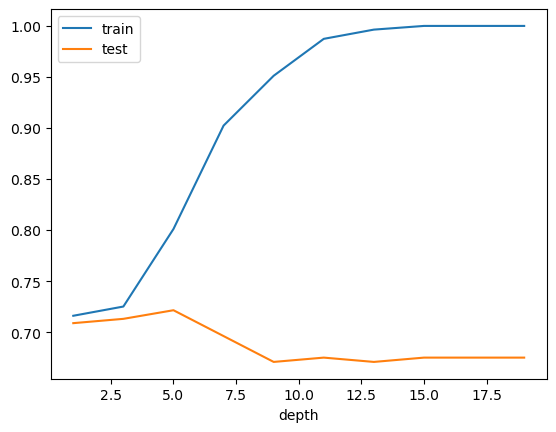

In [30]:
# Plot the scores dataframe with the plot method
scores_df.plot()

In [31]:
# it looks like the lines start to diverge a lot after 3
# Create and train a RandomForest model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth = 3, n_estimators=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print(accuracy_score(y_train, y_pred))

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7215189873417721
0.7088607594936709


# Grid Search CV Optimization

In [32]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
# Create three Random Forest classifiers
#from sklearn.neighbors import KNeighborsClassifier
untuned_model = RandomForestClassifier()
grid_tuned_model = RandomForestClassifier()
random_tuned_model = RandomForestClassifier()

In [34]:
# Train a model without tuning
#from sklearn.metrics import classification_report
untuned_model.fit(X_train, y_train)
untuned_y_pred = untuned_model.predict(X_test)
print(classification_report(y_test, untuned_y_pred,target_names=['-1','0','1']))
                

              precision    recall  f1-score   support

          -1       0.41      0.37      0.39        38
           0       0.78      0.82      0.80       168
           1       0.32      0.29      0.31        31

    accuracy                           0.68       237
   macro avg       0.51      0.49      0.50       237
weighted avg       0.66      0.68      0.67       237



In [35]:
# Create the grid search estimator along with a parameter object containing the values to adjust.
# Adjusted min_samples_split with values of 1 through 10. Adjust min_samples_leaf with values 1 through 10, and 500.
# Include min_weight_fraction_leaf.
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_weight_fraction_leaf':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
             }
grid = GridSearchCV(untuned_model, param_grid, verbose=3)

In [36]:
# Fit the model by using the grid search estimator.
# This will take the Random Forest model and try each combination of parameters.
grid.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV 1/5] END min_samples_leaf=1, min_samples_split=1, min_weight_fraction_leaf=0.0;, score=nan total time=   0.0s
[CV 2/5] END min_samples_leaf=1, min_samples_split=1, min_weight_fraction_leaf=0.0;, score=nan total time=   0.0s
[CV 3/5] END min_samples_leaf=1, min_samples_split=1, min_weight_fraction_leaf=0.0;, score=nan total time=   0.0s
[CV 4/5] END min_samples_leaf=1, min_samples_split=1, min_weight_fraction_leaf=0.0;, score=nan total time=   0.0s
[CV 5/5] END min_samples_leaf=1, min_samples_split=1, min_weight_fraction_leaf=0.0;, score=nan total time=   0.0s
[CV 1/5] END min_samples_leaf=1, min_samples_split=1, min_weight_fraction_leaf=0.1;, score=nan total time=   0.0s
[CV 2/5] END min_samples_leaf=1, min_samples_split=1, min_weight_fraction_leaf=0.1;, score=nan total time=   0.0s
[CV 3/5] END min_samples_leaf=1, min_samples_split=1, min_weight_fraction_leaf=0.1;, score=nan total time=   0.0s
[CV 4/5] END min_samples

c:\Users\Essence\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
300 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Essence\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Essence\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Essence\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  F

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5]},
             verbose=3)

In [37]:
# List the best parameters for this dataset
print(grid.best_params_)

{'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0}


In [38]:
# Print the classification report for the best model
grid_y_pred = grid.predict(X_test)
print(classification_report(y_test, grid_y_pred,target_names=['1','0','1'])) 

              precision    recall  f1-score   support

           1       0.44      0.39      0.42        38
           0       0.80      0.86      0.83       168
           1       0.32      0.23      0.26        31

    accuracy                           0.70       237
   macro avg       0.52      0.49      0.50       237
weighted avg       0.68      0.70      0.69       237

